In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.inspection import PartialDependenceDisplay
from scipy.optimize import curve_fit
import shap
%matplotlib inline

In [2]:
df = pd.read_csv("criteria_final_data.csv")

In [3]:
df

,Pixel Count Score,Sharpness Score,Off-Angle Score,Dilation Score,GLS Score,Quality Score
0,4.03,14.98,6.86,65.67,5.76,0.74
1,3.51,14.86,5.81,87.50,5.84,0.69
2,4.73,18.27,5.84,61.24,6.47,0.78
3,3.46,21.04,5.18,28.90,6.59,0.73
4,4.40,12.15,5.81,66.76,5.99,0.72
...,...,...,...,...,...,...
2125,1.34,12.74,12.71,91.80,5.68,0.67
2126,2.04,18.99,5.48,14.11,5.42,0.77
2127,5.95,16.71,3.71,39.35,5.98,0.74
2128,4.77,10.84,11.42,70.94,6.16,0.67


In [4]:
df.columns

Index(['Pixel Count Score', 'Sharpness Score', 'Off-Angle Score',
       'Dilation Score', 'GLS Score', 'Quality Score'],
      dtype='object')

In [5]:
df = df.dropna(subset=[col for col in df.columns if col != 'Image Name'])

In [6]:
df.describe()

,Pixel Count Score,Sharpness Score,Off-Angle Score,Dilation Score,GLS Score,Quality Score
count,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000
mean,3.992977,16.659732,11.277127,78.802451,5.943601,0.714324
std,1.862505,5.748984,11.920483,18.541208,0.465298,0.044377
min,0.160000,6.680000,0.000000,1.910000,4.120000,0.660000
25%,2.582500,12.762500,5.770000,71.622500,5.630000,0.680000
50%,3.670000,15.335000,9.760000,84.970000,5.920000,0.700000
75%,5.367500,18.877500,14.430000,92.217500,6.250000,0.740000
max,19.640000,46.420000,322.000000,100.000000,7.660000,0.910000


In [7]:
numeric_df_column = df.select_dtypes(include='float64')

In [8]:
def draw_correlation_plot(dataframe_columns):
    correlation_matrix = dataframe_columns.corr()

    plt.figure(figsize=(16, 12))

    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm_r",  
        vmin=-1, 
        vmax=1, 
        center=0, 
        square=True, 
        cbar=True, 
        linewidths=0.5,
        annot_kws={"size": 8}
    )

    plt.title("Correlation Matrix of Iris Qality Assessment", fontsize=16)
    plt.show()

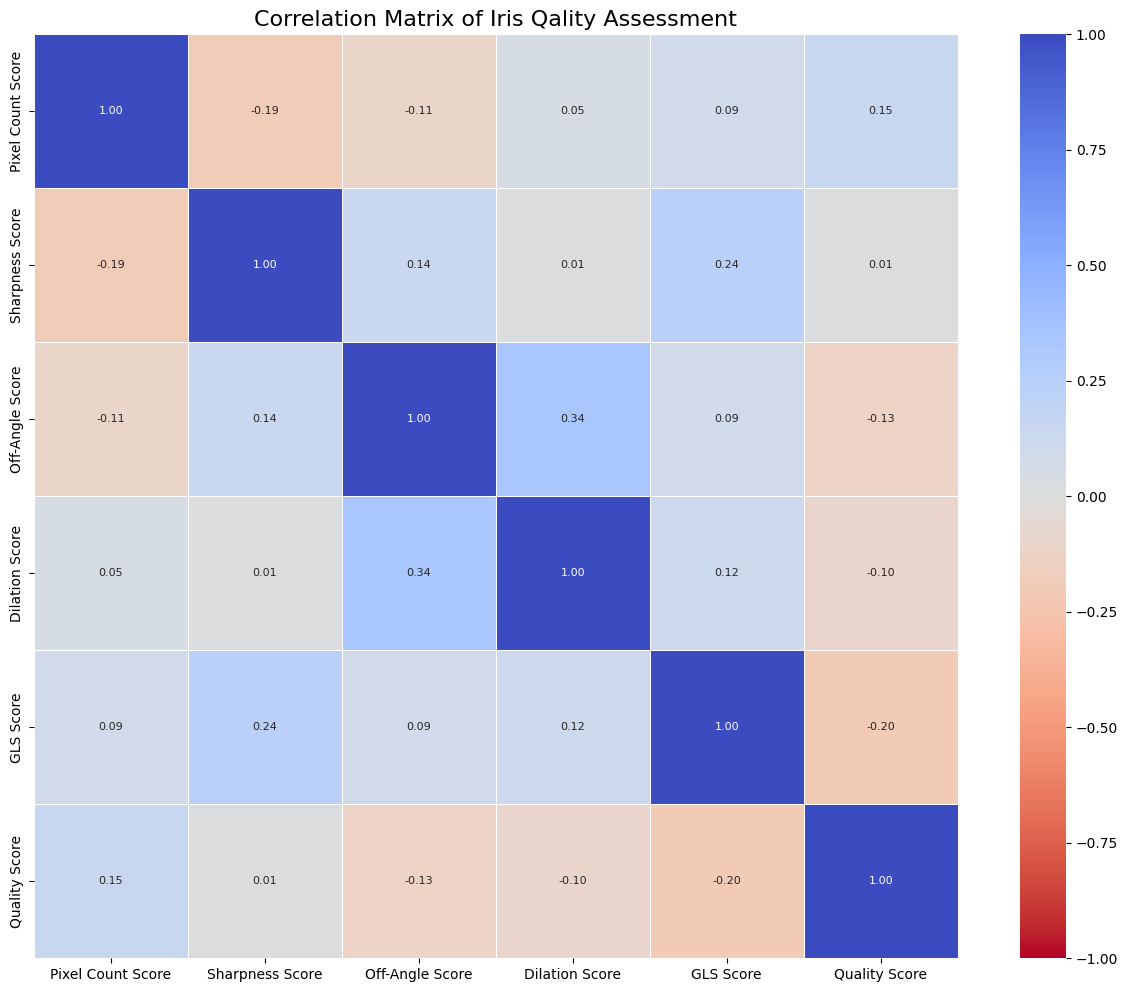

In [9]:
draw_correlation_plot(numeric_df_column)

In [10]:
def check_nonlinear_relationship_rf(data, features, target):
    X = data[features]
    y = data[target]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importance = model.feature_importances_

    print("Feature Importance:")
    for f, imp in zip(features, feature_importance):
        print(f"{f}: {imp:.4f}")

    return model

In [11]:
def check_nonlinear_relationship_kernel(data, features, target):
    if not all(col in data.columns for col in features):
        raise ValueError(f"Some feature columns are not in the DataFrame: {features}")
    if target not in data.columns:
        raise ValueError(f"Target column '{target}' is not in the DataFrame.")

    X = data[features]
    y = data[target]

    model = KernelRidge(kernel='rbf', alpha=1.0, gamma=0.1)
    
    model.fit(X, y)
    
    return model

In [12]:
feature_columns = [col for col in numeric_df_column if col != "Quality Score"]
random_forest = check_nonlinear_relationship_rf(df, feature_columns, "Quality Score")
kernel_regression = check_nonlinear_relationship_kernel(df, feature_columns, "Quality Score")

R² Score (Random Forest): 0.8927
Feature Importance:
Pixel Count Score: 0.2473
Sharpness Score: 0.1873
Off-Angle Score: 0.1684
Dilation Score: 0.1908
GLS Score: 0.2062
Training Kernel Ridge model...
R² Score (Kernel Ridge): -4.8906


In [13]:
def check_nonlinear_relationship_shap(model, data, features):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data[features])

    shap.summary_plot(shap_values, data[features], plot_type="bar")
    shap.summary_plot(shap_values, data[features])

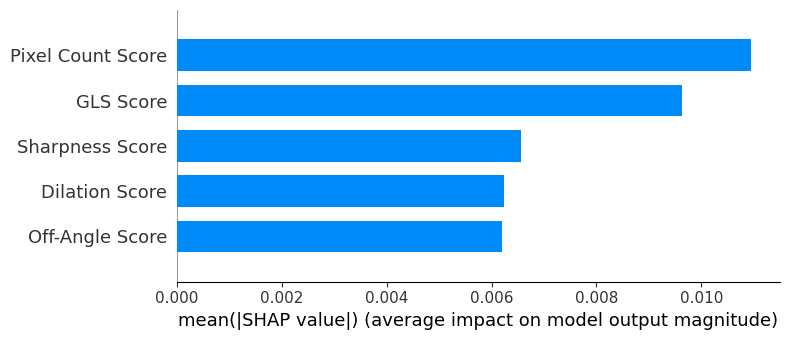

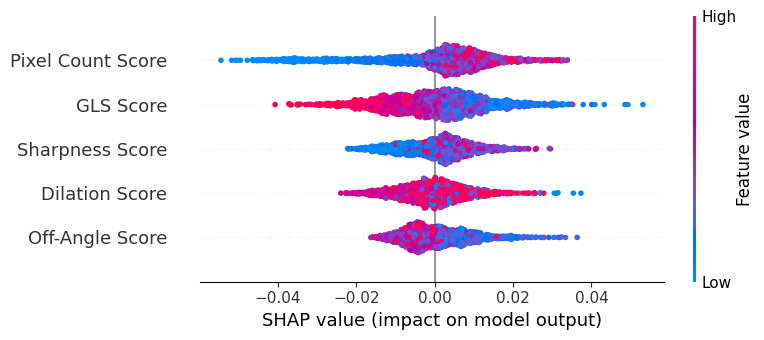

(<shap.explainers._tree.TreeExplainer at 0x26144ed6110>,
 array([[ 0.01344977,  0.00455968,  0.00720111, -0.00193542,  0.00550062],
        [-0.00028977,  0.00029645, -0.00011222, -0.00688578, -0.0011329 ],
        [ 0.01732004,  0.01124933,  0.01874417,  0.00394225, -0.00778001],
        ...,
        [ 0.01582141,  0.00479969,  0.01785458,  0.00811714,  0.00058295],
        [ 0.00068202, -0.0136888 , -0.00831791, -0.01267186, -0.00982768],
        [ 0.03061962,  0.0159619 ,  0.02100619,  0.0132787 ,  0.04930937]]))

In [14]:
check_nonlinear_relationship_shap(random_forest, df, feature_columns)

In [15]:
def check_nonlinear_relationship_pdp(model, data, features):
    display = PartialDependenceDisplay.from_estimator(
        model, 
        data[features],
        features=features
    )
    
    
    plt.tight_layout()
    plt.show()


Checking partial dependence plots for the following features: ['Pixel Count Score', 'Sharpness Score', 'Off-Angle Score', 'Dilation Score', 'GLS Score']
Using model: RandomForestRegressor(random_state=42)
Displaying partial dependence plots...


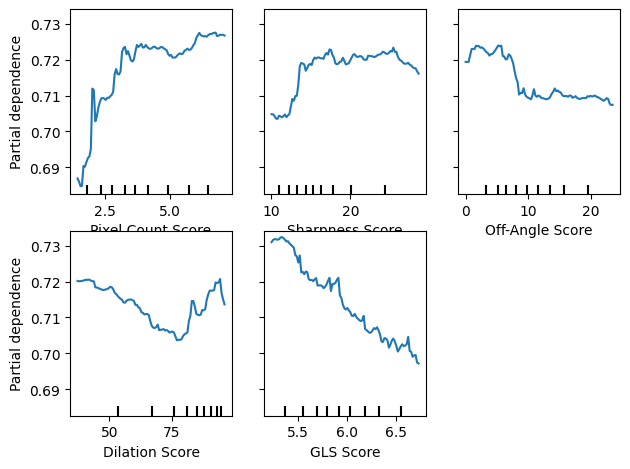

Checking partial dependence plots for the following features: ['Pixel Count Score', 'Sharpness Score', 'Off-Angle Score', 'Dilation Score', 'GLS Score']
Using model: KernelRidge(alpha=1.0, gamma=0.1, kernel='rbf')
Displaying partial dependence plots...


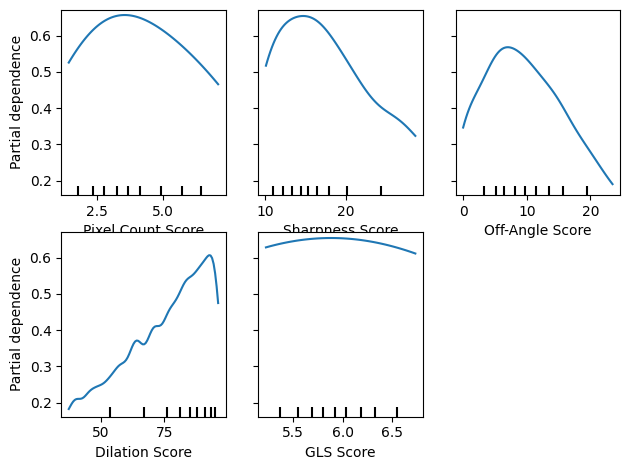

In [16]:
check_nonlinear_relationship_pdp(random_forest, df, feature_columns)
check_nonlinear_relationship_pdp(kernel_regression, df, feature_columns)

In [17]:
df

,Pixel Count Score,Sharpness Score,Off-Angle Score,Dilation Score,GLS Score,Quality Score
0,4.03,14.98,6.86,65.67,5.76,0.74
1,3.51,14.86,5.81,87.50,5.84,0.69
2,4.73,18.27,5.84,61.24,6.47,0.78
3,3.46,21.04,5.18,28.90,6.59,0.73
4,4.40,12.15,5.81,66.76,5.99,0.72
...,...,...,...,...,...,...
2125,1.34,12.74,12.71,91.80,5.68,0.67
2126,2.04,18.99,5.48,14.11,5.42,0.77
2127,5.95,16.71,3.71,39.35,5.98,0.74
2128,4.77,10.84,11.42,70.94,6.16,0.67


In [78]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Extract columns
pixel_count = df['Pixel Count Score']
sharpness = df['Sharpness Score']
off_angle = df['Off-Angle Score']
dilation = df['Dilation Score']
gls = df['GLS Score']
quality_score = df['Quality Score']

# Define the fusion function (combining all factors)
def fusion_function(x, a1, b1, a2, b2, a3, b3, c3, a4, b4, a5, b5, C):
    pixel, sharp, angle, dilate, gls = x[0], x[1], x[2], x[3], x[4]
    return (
        a1 * pixel**2 + b1 * pixel +
        a2 * sharp**2 + b2 * sharp +
        a3 * angle**3 + b3 * angle**2 + c3*angle +
        a4 * dilate**2 + b4 * dilate +
        a5 * gls**2 + b5 * gls +
        C
    )

input_data = np.vstack((pixel_count, sharpness, off_angle, dilation, gls))
coeff, _ = curve_fit(
    fusion_function, input_data, quality_score
)

a1, b1, a2, b2, a3, b3, c3, a4, b4, a5, b5, C = coeff

predicted_quality = fusion_function(input_data, *coeff)


In [79]:
fusion_function((13.03, 10.9, 6.99, 83.94, 5.86), *coeff)

np.float64(0.689947278724839)